In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import utils
import os

C:\Users\msubr\Anaconda3\envs\bert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("../data/UCF-crime-frames-descriptions-partitions.csv")

In [3]:
train = data.loc[data["partition"] == "train"]
val = data.loc[data["partition"] == "validation"]

In [4]:
X = np.load("../data/train.npy")
X = np.concatenate([X,np.load("../data/train_qformer.npy")], axis=1)
V = np.load("../data/val.npy")
V = np.concatenate([V,np.load("../data/val_qformer.npy")], axis=1)
X = torch.tensor(X, dtype=torch.float32)
V = torch.tensor(V, dtype=torch.float32)
y = list(train["class"])
y = np.array([utils.labels[lbl] for lbl in y])
y = torch.tensor(y, dtype=torch.float32)
y_val = list(val["class"])
y_val = np.array([utils.labels[lbl] for lbl in y_val])
y_val = torch.tensor(y_val, dtype=torch.float32)

In [12]:
labels_counts = torch.tensor([(y==i).sum() for i in range(len(utils.labels))])
weights = 1 - labels_counts / len(X)   

In [18]:
model = nn.Sequential(
    nn.Linear(2176, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Sequential(
  (0): Linear(in_features=2176, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=10, bias=True)
)

In [20]:
weights = weights.to(device)
loss_fn = nn.CrossEntropyLoss(weights)
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [21]:
n_epochs = 30
batch_size = 64
for epoch in range(n_epochs):
    acc = 0
    perm = torch.randperm(len(X))
    for i in range(0, len(X), batch_size):
        Xbatch = X[perm[i:i+batch_size]]
        Xbatch = Xbatch.to(device)
        y_pred = model(Xbatch)
        ybatch = y[perm[i:i+batch_size]]
        ybatch = ybatch.type(torch.LongTensor)
        ybatch = ybatch.to(device)
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc += utils.get_acc(y_pred, ybatch, return_sum=True)
    val_pred = utils.evaluate(V, model, device, batch_size)
        
    print(f'Finished epoch {epoch}, latest loss {loss}, acc {acc/len(X)} val_acc {utils.get_acc(val_pred, y_val)}')

Finished epoch 0, latest loss 0.7470710873603821, acc 0.7429538369178772 val_acc 0.7110708951950073
Finished epoch 1, latest loss 0.5528160333633423, acc 0.8198477625846863 val_acc 0.6994309425354004
Finished epoch 2, latest loss 0.6602857708930969, acc 0.8433525562286377 val_acc 0.6917744278907776
Finished epoch 3, latest loss 0.39922401309013367, acc 0.8577550649642944 val_acc 0.6717537641525269
Finished epoch 4, latest loss 0.3702569305896759, acc 0.8682267069816589 val_acc 0.6732540130615234
Finished epoch 5, latest loss 0.4637163579463959, acc 0.8766523599624634 val_acc 0.666114866733551
Finished epoch 6, latest loss 0.3438066244125366, acc 0.8845221400260925 val_acc 0.6442317366600037
Finished epoch 7, latest loss 0.15612131357192993, acc 0.8903701901435852 val_acc 0.6441283226013184
Finished epoch 8, latest loss 0.17946577072143555, acc 0.8950985074043274 val_acc 0.6326953172683716
Finished epoch 9, latest loss 0.2410890907049179, acc 0.8986185789108276 val_acc 0.639989674091339

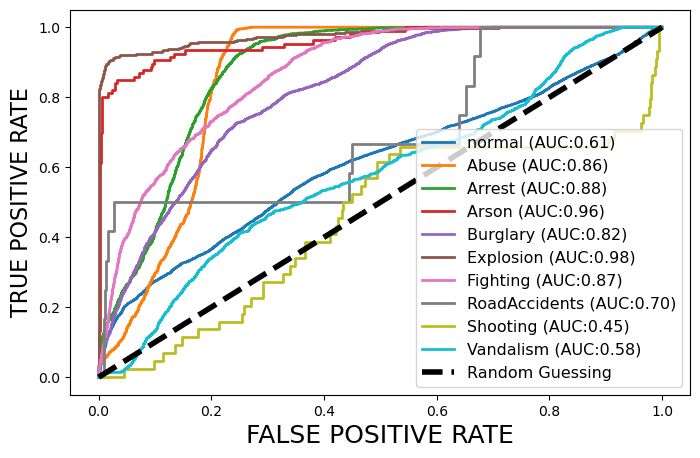

ROC AUC score: 0.769687281284126


In [24]:
print('ROC AUC score:', utils.multiclass_roc_auc_score(y_val , val_pred, average = "macro"))

In [27]:
utils.get_acc_per_lbl(val_pred, y_val)
print("Acc:", utils.get_acc(val_pred, y_val))

0, presc 0.70, recall 0.76, f1 0.73	 total 12895 Normal
1, presc 0.22, recall 0.20, f1 0.21	 total 646 Abuse
2, presc 0.46, recall 0.13, f1 0.20	 total 1321 Arrest
3, presc 0.25, recall 0.81, f1 0.39	 total 106 Arson
4, presc 0.13, recall 0.20, f1 0.16	 total 1767 Burglary
5, presc 0.21, recall 0.07, f1 0.10	 total 388 Explosion
6, presc 0.33, recall 0.06, f1 0.11	 total 1132 Fighting
7, presc 0.00, recall 0.00, f1 nan	 total 12 RoadAccidents
8, presc 0.00, recall 0.02, f1 0.00	 total 44 Shooting
9, presc 0.12, recall 0.06, f1 0.08	 total 1019 Vandalism
Acc: tensor(0.5507)


In [ ]:
torch.save(model.state_dict(), "models/model_image_all_features.pt")